In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import pickle

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Sklearn and Imbalanced-learn Libraries
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV, VarianceThreshold, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, balanced_accuracy_score,
    classification_report
)
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.utils import resample
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE




from sklearn.base import BaseEstimator, TransformerMixin

# Additional Libraries
from sklearn.base import clone
from sklearn.exceptions import NotFittedError
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries with GPU Support
import xgboost as xgb
import lightgbm as lgb

# For SHAP values
import shap

# Statistical Tests
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

# For progress monitoring
from tqdm import tqdm
from kneed import KneeLocator


import warnings

# Suppress warnings to reduce clutter
warnings.filterwarnings('ignore')

from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from joblib import Parallel, delayed
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd

# Necessary imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
from sklearn.utils.validation import check_X_y, check_array
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')



In [2]:
# File paths
clinical_data_path = '/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/Clinical_and_Other_Features_final_comb.xlsx'
features_path = '/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/features_extracted_VGG16.pkl.gz'

In [3]:
#Function: Load and Process Data
def load_clinical_data(clinical_data_path):
    """
    Loads and preprocesses clinical data from an Excel file.

    Parameters:
    - clinical_data_path (str): Path to the clinical data Excel file.

    Returns:
    - pd.DataFrame: Preprocessed clinical data.
    """
    print("Loading clinical data...")
    clinical_data = pd.read_excel(clinical_data_path)

    # Rename columns for consistency
    clinical_data.columns = [col.replace(' ', '_') for col in clinical_data.columns]
    clinical_data = clinical_data.rename(
        columns={
            'Patient_ID': 'patient_id',
            'Pathologic_Response_to_Neoadjuvant_Therapy': 'response'
        }
    )

    # Convert 'Breast_MRI_001' to '001' in the patient_id column
    clinical_data['patient_id'] = clinical_data['patient_id'].apply(
        lambda x: x.split('_')[-1] if isinstance(x, str) else x
    )

    # Convert response to binary: 1 means pCR, else non-pCR
    clinical_data['response'] = clinical_data['response'].apply(
        lambda x: 1 if x == 1 else 0
    )

    # Preprocess clinical data
    clinical_data['patient_id'] = clinical_data['patient_id'].astype(str)

    # Separate numerical and categorical columns
    patient_id_cols = ["patient_id"]
    response_cols = ["response"]
    numerical_cols = ["Date_of_Birth"]  # Consider converting to 'Age at Diagnosis'
    categorical_cols = clinical_data.columns[
        (clinical_data.columns != "Date_of_Birth") &
        (clinical_data.columns != "patient_id") &
        (clinical_data.columns != "response")
    ]

    numerical_df = clinical_data[numerical_cols]
    patient_id_df = clinical_data[patient_id_cols]
    response_df = clinical_data[response_cols]

    # One-hot encode categorical columns
    clinical_data[categorical_cols] = clinical_data[categorical_cols].astype('category')
    categorical_df = pd.get_dummies(clinical_data[categorical_cols], drop_first=True)
    categorical_df = categorical_df.astype(int)

    # Concatenate all dataframes
    encoded_df = pd.concat(
        [patient_id_df, numerical_df, categorical_df, response_df],
        axis=1
    )

    print("Clinical data loaded and processed.")
    return encoded_df

def load_image_features(features_path):
    """
    Loads and processes image features from a compressed pickle file.

    Parameters:
    - features_path (str): Path to the compressed pickle file containing image features.

    Returns:
    - pd.DataFrame: Processed image features.
    """
    print("Loading image features...")
    with gzip.open(features_path, 'rb') as f:
        features_dict = pickle.load(f)

    # Extract patient IDs and features
    features_data = {
        'patient_id': [key.split('-')[0] for key in features_dict.keys()],
        **{
            f'feature_{i}': [features_dict[key][i] for key in features_dict.keys()]
            for i in range(len(next(iter(features_dict.values()))))
        }
    }

    # Create a DataFrame
    features_df = pd.DataFrame(features_data)
    features_df['patient_id'] = features_df['patient_id'].astype(str)
    print("Image features loaded.")
    return features_df



def load_and_preprocess_data(clinical_data_path, features_path):
    clinical_data_processed = load_clinical_data(clinical_data_path)
    features_df = load_image_features(features_path)
    clinical_data_processed['patient_id'] = clinical_data_processed['patient_id'].astype(str)
    features_df['patient_id'] = features_df['patient_id'].astype(str)

    # Prepare three variations of the dataset
    print("Preparing dataset variations...")

    datasets = {}

    # Handle missing data in image features
    print("Imputing missing values in image features...")
    imputer = SimpleImputer(strategy='mean')
    features_df_imputed = imputer.fit_transform(features_df.drop(columns=['patient_id']))

    # Feature scaling
    print("Scaling image features...")
    scaler = MinMaxScaler()
    features_df_scaled = scaler.fit_transform(features_df_imputed)

    # Create a DataFrame for scaled features
    features_scaled_df = pd.DataFrame(features_df_scaled, columns=[f'feature_{i}' for i in range(features_df_scaled.shape[1])])
    features_scaled_df['patient_id'] = features_df['patient_id'].values

    # Now, merge scaled image features with clinical data
    data_scaled = features_scaled_df.merge(
        clinical_data_processed,
        on='patient_id',
        how='inner'
    ).reset_index(drop=True)

    # 1. Image Features (Scaled)
    image_feature_columns = [col for col in data_scaled.columns if 'feature_' in col]

    X_image = data_scaled[image_feature_columns]
    y_image = data_scaled['response'].astype(int)
    groups_image = data_scaled['patient_id']

    # 2. Clinical Features
    # Subset clinical data to include only patients present in data_scaled
    patient_ids_in_data_scaled = clinical_data_processed['patient_id'].isin(data_scaled['patient_id'])
    clinical_data_in_data_scaled = clinical_data_processed[patient_ids_in_data_scaled].reset_index(drop=True)

    X_clinical = clinical_data_in_data_scaled.drop(columns=['patient_id', 'response'])
    y_clinical = clinical_data_in_data_scaled['response'].astype(int)
    groups_clinical = clinical_data_in_data_scaled['patient_id']

    # 3. Combined Features (Scaled image features + clinical data)
    # Exclude 'patient_id' and 'response' from features
    exclude_columns = ['patient_id', 'response']
    X_combined = data_scaled.drop(columns=exclude_columns)
    y_combined = data_scaled['response'].astype(int)
    groups_combined = data_scaled['patient_id']

    # Preprocess each dataset variation
    def preprocess_data(X):
        # Remove features with zero variance
        variance_threshold = VarianceThreshold(threshold=0)
        X_var = variance_threshold.fit_transform(X)
        feature_names = X.columns[variance_threshold.get_support(indices=True)]
        X = pd.DataFrame(X_var, columns=feature_names)
        return X

    X_combined = preprocess_data(X_combined)
    X_clinical = preprocess_data(X_clinical)
    X_image = preprocess_data(X_image)

    datasets['Combined'] = (X_combined, y_combined, groups_combined)
    datasets['Clinical'] = (X_clinical, y_clinical, groups_clinical)
    datasets['Image'] = (X_image, y_image, groups_image)

    return datasets


In [4]:
# Load and preprocess the data
data_variations = load_and_preprocess_data(clinical_data_path, features_path)

Loading clinical data...
Clinical data loaded and processed.
Loading image features...
Image features loaded.
Preparing dataset variations...
Imputing missing values in image features...
Scaling image features...


In [5]:
#Data Train Test Split
def stratified_group_split(X, y, groups, test_size=0.2, random_state=None):
    # Create a DataFrame with groups and their corresponding class labels
    group_df = pd.DataFrame({'group': groups, 'label': y})
    group_df = group_df.drop_duplicates()

    # Perform stratified split on groups
    stratify = group_df['label']
    group_train, group_test = train_test_split(
        group_df['group'], test_size=test_size, random_state=random_state, stratify=stratify
    )

    # Select samples based on group splits
    train_idx = X[groups.isin(group_train)].index
    test_idx = X[groups.isin(group_test)].index

    return train_idx, test_idx

# Usage
data_splits = {}

for dataset_name, (X_full, y_full, groups) in data_variations.items():
    print(f"\nProcessing {dataset_name} Dataset")

    # Ensure groups is a pandas Series with reset index
    groups = pd.Series(groups).reset_index(drop=True)
    y_full_series = pd.Series(y_full).reset_index(drop=True)
    X_full = X_full.reset_index(drop=True)

    train_idx, test_idx = stratified_group_split(X_full, y_full_series, groups, test_size=0.2, random_state=42)

    X_train_full = X_full.loc[train_idx].reset_index(drop=True)
    y_train_full = y_full_series.loc[train_idx].reset_index(drop=True)
    X_test_full = X_full.loc[test_idx].reset_index(drop=True)
    y_test = y_full_series.loc[test_idx].reset_index(drop=True)

    # Retrieve patient IDs for train and test sets
    patient_ids_train = groups.loc[train_idx].reset_index(drop=True)
    patient_ids_test = groups.loc[test_idx].reset_index(drop=True)

    data_splits[dataset_name] = {
        'X_train_full': X_train_full,
        'X_test_full': X_test_full,
        'y_train_full': y_train_full,
        'y_test': y_test,
        'patient_ids_train': patient_ids_train,
        'patient_ids_test': patient_ids_test
    }

    # Verify class distribution
    print("Training set class distribution:")
    print(y_train_full.value_counts(normalize=True))
    print("Test set class distribution:")
    print(y_test.value_counts(normalize=True))


Processing Combined Dataset
Training set class distribution:
response
0    0.792833
1    0.207167
Name: proportion, dtype: float64
Test set class distribution:
response
0    0.759479
1    0.240521
Name: proportion, dtype: float64

Processing Clinical Dataset
Training set class distribution:
response
0    0.770335
1    0.229665
Name: proportion, dtype: float64
Test set class distribution:
response
0    0.773585
1    0.226415
Name: proportion, dtype: float64

Processing Image Dataset
Training set class distribution:
response
0    0.792833
1    0.207167
Name: proportion, dtype: float64
Test set class distribution:
response
0    0.759479
1    0.240521
Name: proportion, dtype: float64


In [6]:
#Function: MannWhitney & RFECV Feature Selection
class MannWhitneyUTestFeatureSelector(BaseEstimator, TransformerMixin):
    """
    Custom transformer for feature selection using the Mann-Whitney U test
    with Bonferroni correction and optional parallelization.
    """
    def __init__(self, alpha=0.05, bonferroni=True, n_jobs=-1):
        """
        Initialize the selector.

        Parameters:
        - alpha (float): The significance level for the Mann-Whitney U test.
        - bonferroni (bool): Whether to apply Bonferroni correction.
        - n_jobs (int): The number of jobs to run in parallel (default is -1, using all available cores).
        """
        self.alpha = alpha
        self.bonferroni = bonferroni
        self.n_jobs = n_jobs
        self.selected_features_ = None

    def _perform_test(self, col, X, y):
        """
        Helper function to perform Mann-Whitney U test on a single feature.
        """
        group0 = X.loc[y == 0, col]
        group1 = X.loc[y == 1, col]
        try:
            _, p = mannwhitneyu(group0, group1, alternative='two-sided')
        except ValueError:
            p = 1  # Assign high p-value if test fails
        return p

    def fit(self, X, y):
        """
        Fit the selector to the data by performing the Mann-Whitney U test for each feature.
        
        Parameters:
        - X (pd.DataFrame): The input feature matrix.
        - y (pd.Series): The target variable.
        
        Returns:
        - self: The fitted selector.
        """
        # Ensure X is a DataFrame and y is a Series with matching indices
        X = pd.DataFrame(X)
        y = pd.Series(y, index=X.index)
        
        # Parallelized Mann-Whitney U tests
        p_values = Parallel(n_jobs=self.n_jobs)(
            delayed(self._perform_test)(col, X, y) for col in X.columns
        )
        
        self.p_values_ = np.array(p_values)
        
        # Apply Bonferroni correction if needed
        if self.bonferroni:
            corrected_alpha = self.alpha / X.shape[1]  # Adjust alpha by number of tests
        else:
            corrected_alpha = self.alpha

        # Select features with p-values below the corrected alpha level
        self.selected_features_ = X.columns[self.p_values_ < corrected_alpha]
        
        return self

    def transform(self, X):
        """
        Transform the data by selecting the features that passed the Mann-Whitney U test.

        Parameters:
        - X (pd.DataFrame): The input feature matrix.

        Returns:
        - pd.DataFrame: The selected feature matrix.
        """
        # Ensure X is a DataFrame
        X = pd.DataFrame(X)
        return X.loc[:, self.selected_features_]
    
def manual_rfecv(X, y, groups, estimator, cv, scoring='f1', min_features_to_select=5, step=0.1, early_stopping_rounds=3):
    """
    Manually performs Recursive Feature Elimination with Cross-Validation (RFECV)
    using the specified estimator and cross-validation strategy.
    
    Parameters:
    - X (pd.DataFrame): Feature matrix.
    - y (pd.Series): Target vector.
    - groups (pd.Series or array-like): Group labels for the samples used while splitting the dataset.
    - estimator: The machine learning estimator to use for feature selection.
    - cv: Cross-validation strategy.
    - scoring (str): Scoring metric (default is 'f1').
    - min_features_to_select (int): Minimum number of features to select.
    - step (float): Proportion of features to remove at each iteration.
    - early_stopping_rounds (int): Number of rounds to wait for improvement before stopping.
    
    Returns:
    - best_features (list): The list of best selected features based on cross-validation score.
    - history (pd.DataFrame): History of number of features and corresponding CV scores.
    """
    
    n_features = X.shape[1]
    step_num = int(max(1, step * n_features))  # Convert the step percentage to an absolute number of features
    
    # History to keep track of scores, feature sets and feature counts
    history = []
    feature_sets = []
    
    # Copy X to avoid modifying the original dataframe
    X_remaining = X.copy()

    # Early stopping tracking
    no_improvement_rounds = 0
    best_score = -np.inf
    
    while X_remaining.shape[1] > min_features_to_select:
        print(f"Evaluating with {X_remaining.shape[1]} features...")
        n_features_remaining = X_remaining.shape[1]
        step_num = int(max(1, step * n_features_remaining)) 
        
        # Custom cross-validation loop
        scores = []
        for train_idx, test_idx in cv.split(X_remaining, y, groups):
            X_train_cv, X_valid_cv = X_remaining.iloc[train_idx], X_remaining.iloc[test_idx]
            y_train_cv, y_valid_cv = y.iloc[train_idx], y.iloc[test_idx]
            estimator.fit(X_train_cv, y_train_cv)
            y_pred_cv = estimator.predict(X_valid_cv)
            score = f1_score(y_valid_cv, y_pred_cv)
            scores.append(score)
        avg_score = np.mean(scores)
        
        # Append results to the history and store the current feature set
        history.append((X_remaining.shape[1], round(avg_score, 2)))  # Round CV score to 2 decimal places
        feature_sets.append(X_remaining.columns.tolist())
        
        # Early stopping check
        if avg_score > best_score:
            best_score = avg_score
            no_improvement_rounds = 0
        else:
            no_improvement_rounds += 1
        
        if no_improvement_rounds >= early_stopping_rounds:
            print("Early stopping, no significant improvement.")
            break
        
        # Train the model and get feature importances
        estimator.fit(X_remaining, y)
        importances = estimator.feature_importances_
        
        # Create a DataFrame of features and importances
        feature_importances = pd.DataFrame({
            'feature': X_remaining.columns,
            'importance': importances
        })
        
        # Sort features by importance (ascending)
        feature_importances.sort_values(by='importance', ascending=True, inplace=True)
        
        # Remove the least important features based on step size
        n_to_remove = min(step_num, X_remaining.shape[1] - min_features_to_select)
        features_to_remove = feature_importances.head(n_to_remove)['feature'].tolist()
        
        # Drop the least important features
        X_remaining.drop(columns=features_to_remove, inplace=True)
    
    # Convert history to a DataFrame for easy access
    history_df = pd.DataFrame(history, columns=['n_features', 'cv_score'])
    
    # Identify the best cross-validation score and the corresponding feature sets with the least number of features
    max_score = history_df['cv_score'].max()
    best_idx = history_df[history_df['cv_score'] == max_score]['n_features'].idxmin()  # Minimize the number of features
    
    # The best selected features correspond to the maximum cross-validation score with the least features
    best_features = feature_sets[best_idx]
    
    return best_features, history_df



Starting feature selection for 'Combined' Dataset

Handling missing data with SimpleImputer...

Scaling features with MinMaxScaler...

Performing L1-based feature selection...
Number of features after L1-based selection: 100

Performing Mann-Whitney U Test feature selection with Bonferroni correction and parallelization...
Number of features after Mann-Whitney U Test: 77

Performing Recursive Feature Elimination with Cross-Validation (RFECV)...
Evaluating with 77 features...
Evaluating with 70 features...
Evaluating with 63 features...
Evaluating with 57 features...
Evaluating with 52 features...
Evaluating with 47 features...
Evaluating with 43 features...
Evaluating with 39 features...
Evaluating with 36 features...
Evaluating with 33 features...
Evaluating with 30 features...
Evaluating with 27 features...
Evaluating with 25 features...
Evaluating with 23 features...
Evaluating with 21 features...
Evaluating with 19 features...
Evaluating with 18 features...
Evaluating with 17 feat

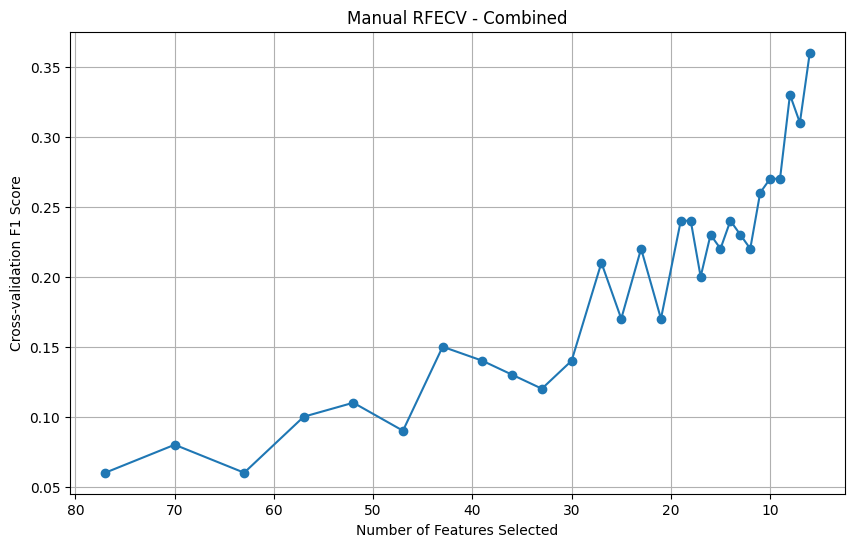


Skipping SMOTE. Using original training data.

Final datasets for 'Combined' stored with selected features.

Starting feature selection for 'Clinical' Dataset

Skipping feature selection for 'Clinical' dataset. Retaining all original features.

Starting feature selection for 'Image' Dataset

Handling missing data with SimpleImputer...

Scaling features with MinMaxScaler...

Performing L1-based feature selection...
Number of features after L1-based selection: 100

Performing Mann-Whitney U Test feature selection with Bonferroni correction and parallelization...
Number of features after Mann-Whitney U Test: 78

Performing Recursive Feature Elimination with Cross-Validation (RFECV)...
Evaluating with 78 features...
Evaluating with 71 features...
Evaluating with 64 features...
Evaluating with 58 features...
Evaluating with 53 features...
Evaluating with 48 features...
Evaluating with 44 features...
Evaluating with 40 features...
Evaluating with 36 features...
Evaluating with 33 features..

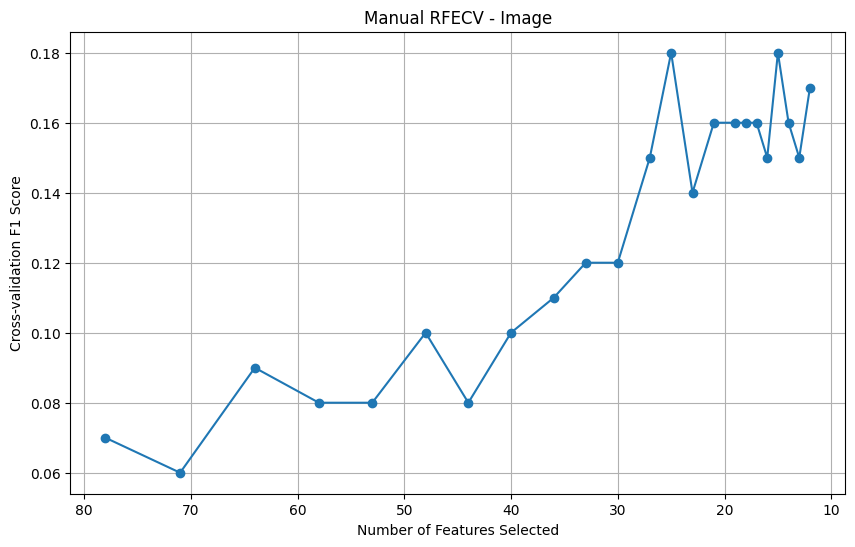


Skipping SMOTE. Using original training data.

Final datasets for 'Image' stored with selected features.


In [7]:
# Feature Selection
selected_features_dict = {}

apply_smote = False  # Set to False if you want to skip SMOTE
apply_mannwhitney = True  # Set to False if you want to skip Mann-Whitney U Test

for dataset_name in data_variations.keys():
    
    print(f"\nStarting feature selection for '{dataset_name}' Dataset")
    
    if dataset_name == 'Clinical':
        print("\nSkipping feature selection for 'Clinical' dataset. Retaining all original features.")
        # No changes needed for 'Clinical' dataset
    else:
        # Retrieve data
        data = data_splits[dataset_name]

        X_train_full = data['X_train_full']
        y_train_full = data['y_train_full']
        X_test_full = data['X_test_full']
        y_test = data['y_test']
        patient_ids_train = data['patient_ids_train']  # Preserving patient IDs
        patient_ids_test = data['patient_ids_test']

        # Handle Missing Data - Imputation
        print("\nHandling missing data with SimpleImputer...")
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_full)
        X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train_full.columns, index=X_train_full.index)

        # Feature Scaling using MinMaxScaler
        print("\nScaling features with MinMaxScaler...")
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_full.columns, index=X_train_full.index)

        # L1-based Feature Selection
        print("\nPerforming L1-based feature selection...")
        l1_selector = SelectFromModel(
            LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000),
            max_features=100  # Adjust as needed
        )
        l1_selector.fit(X_train_scaled, y_train_full)
        X_train_l1 = l1_selector.transform(X_train_scaled)
        X_train_l1 = pd.DataFrame(X_train_l1, columns=X_train_scaled.columns[l1_selector.get_support()])
        print(f"Number of features after L1-based selection: {X_train_l1.shape[1]}")

        # Mann-Whitney U Test Feature Selection
        if apply_mannwhitney:
            print("\nPerforming Mann-Whitney U Test feature selection with Bonferroni correction and parallelization...")
            mannwhitney_selector = MannWhitneyUTestFeatureSelector(alpha=0.05, bonferroni=True, n_jobs=-1)
            mannwhitney_selector.fit(X_train_l1, y_train_full)
            X_train_mwu = mannwhitney_selector.transform(X_train_l1)
            print(f"Number of features after Mann-Whitney U Test: {X_train_mwu.shape[1]}")
        else:
            print("\nSkipping Mann-Whitney U Test. Using L1-selected features.")
            X_train_mwu = X_train_l1

        # Manually perform RFECV using a Random Forest Classifier
        print("\nPerforming Recursive Feature Elimination with Cross-Validation (RFECV)...")
        rf_estimator = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=50, max_depth=7)
        cv_strategy = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

        # Perform manual RFECV, passing groups_train
        best_features, rfecv_history = manual_rfecv(
            X_train_mwu, y_train_full, patient_ids_train, rf_estimator, cv_strategy,
            scoring='f1', min_features_to_select=5, step=0.1, early_stopping_rounds=10
        )

        print(f"\nBest Features Selected: {best_features}")
        print("\nRFECV History:")
        print(rfecv_history)

        # Plot the number of features vs. cross-validation score
        plt.figure(figsize=(10, 6))
        plt.plot(rfecv_history['n_features'], rfecv_history['cv_score'], marker='o')
        plt.xlabel("Number of Features Selected")
        plt.ylabel("Cross-validation F1 Score")
        plt.title(f"Manual RFECV - {dataset_name}")
        plt.gca().invert_xaxis()  # Optional: Invert x-axis to show decreasing number of features
        plt.grid(True)
        plt.show()

        # Apply SMOTE **after** feature selection
        if apply_smote:
            print("\nApplying SMOTE to balance the classes after feature selection...")
            smote = SMOTE(random_state=42)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_mwu[best_features], y_train_full)
            X_train_resampled = pd.DataFrame(X_train_resampled, columns=best_features).reset_index(drop=True)
            y_train_resampled = pd.Series(y_train_resampled).reset_index(drop=True)
            print(f"Number of samples after SMOTE: {X_train_resampled.shape[0]}")
            print(f"Class distribution after SMOTE:\n{y_train_resampled.value_counts()}")
        else:
            print("\nSkipping SMOTE. Using original training data.")
            X_train_resampled = X_train_mwu[best_features].reset_index(drop=True)
            y_train_resampled = y_train_full.reset_index(drop=True)

        # Ensure that all selected features exist in the test dataset
        missing_in_train = set(best_features) - set(X_train_full.columns)
        missing_in_test = set(best_features) - set(X_test_full.columns)
        if missing_in_train:
            raise ValueError(f"The following selected features are missing in X_train_full: {missing_in_train}")
        if missing_in_test:
            raise ValueError(f"The following selected features are missing in X_test_full: {missing_in_test}")

        # Subset the original X_train_full and X_test_full to include only the selected features
        X_test_final = X_test_full[best_features].copy().reset_index(drop=True)
        y_test_final = y_test.reset_index(drop=True)

        # Store the final datasets with selected features in data_splits
        data_splits[dataset_name] = {
            'X_train_full': X_train_resampled,
            'X_test_full': X_test_final,
            'y_train_full': y_train_resampled,
            'y_test': y_test_final,
            'patient_ids_train': patient_ids_train.reset_index(drop=True),
            'patient_ids_test': patient_ids_test.reset_index(drop=True)
        }

        print(f"\nFinal datasets for '{dataset_name}' stored with selected features.")


In [8]:
# Define classifiers and param grid to evaluate
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='liblinear', random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    #'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1,scale_pos_weight=(y_train_full == 0).sum() / (y_train_full == 1).sum()),
    'LightGBM': lgb.LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42, max_iter=5000,class_weight='balanced')
}

# Define classifiers to evaluate
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='liblinear', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    #'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42, max_iter=5000)
}

param_grids = {
    'XGBoost': {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5, 7, 10]
    },
    'LightGBM': {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__num_leaves': [31, 63],
        'classifier__verbose': [-1]
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [100, 150],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5, 7]
    },
    'Logistic Regression': {
        'classifier__C': np.logspace(-4, 4, 10),
        'classifier__penalty': ['l1', 'l2']
    },
    'SVM': {
        'classifier__C': [0.1, 1, 5, 10],
        'classifier__kernel': ['linear', 'rbf']
    }
}

In [9]:
# Function: Nested Cross Validation for Hyperparameter Tuning

def nested_cv_evaluation(dataset_name, X, y, groups, classifiers, param_grids, outer_splits=3, inner_splits=2):
    """
    Performs nested cross-validation with hyperparameter tuning and group-aware splitting.
    """
    print(f"\nStarting Nested CV for {dataset_name} dataset...")
    outer_cv = StratifiedGroupKFold(n_splits=outer_splits, shuffle=True, random_state=42)
    aggregated_scores = {}
    best_estimators = {}
    nested_scores = {name: [] for name in classifiers.keys()}
    cv_results_all = {name: [] for name in classifiers.keys()}  # To store cv_results_

    for name, classifier in classifiers.items():
        print(f"\nEvaluating {name} on {dataset_name} dataset...")
        start_time = time.time()
        scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
        best_estimators[name] = []
        cv_results_list = []  # To collect cv_results_ from each outer fold

        for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y, groups=groups), 1):
            print(f"  Outer Fold {fold}/{outer_splits}")
            X_train_fold, X_valid = X.iloc[train_idx], X.iloc[test_idx]
            y_train_fold, y_valid = y.iloc[train_idx], y.iloc[test_idx]
            groups_train_fold = groups.iloc[train_idx]

            # Define the inner cross-validation with group awareness
            inner_cv = StratifiedGroupKFold(n_splits=inner_splits, shuffle=True, random_state=42)

            # Define the pipeline
            pipeline = ImbPipeline(steps=[
                ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
                ('scaler', MinMaxScaler()),
                ('classifier', classifier)
            ])

            # Hyperparameter tuning with RandomizedSearchCV
            search = RandomizedSearchCV(
                estimator=pipeline,
                param_distributions=param_grids[name],
                scoring='f1',
                n_iter=5,  # Adjusted for efficiency
                cv=inner_cv.split(X_train_fold, y_train_fold, groups=groups_train_fold),
                random_state=42,
                n_jobs=-1
            )

            # Fit the model on the training fold
            search.fit(X_train_fold, y_train_fold)

            # Get the best estimator
            best_model = search.best_estimator_

            # Evaluate on the validation fold
            y_pred = best_model.predict(X_valid)

            # Compute metrics
            accuracy = accuracy_score(y_valid, y_pred)
            precision = precision_score(y_valid, y_pred, zero_division=0)
            recall = recall_score(y_valid, y_pred)
            f1 = f1_score(y_valid, y_pred)

            # Append scores
            scores['accuracy'].append(accuracy)
            scores['precision'].append(precision)
            scores['recall'].append(recall)
            scores['f1'].append(f1)
            nested_scores[name].append(f1)

            # Store the best estimator
            best_estimators[name].append(best_model)

            # Collect cv_results_
            cv_results = pd.DataFrame(search.cv_results_)
            cv_results_list.append(cv_results)

        # Aggregate scores
        aggregated_scores[name] = {metric: (np.mean(scores[metric]), np.std(scores[metric])) for metric in scores}

        # Combine cv_results_ from all outer folds
        cv_results_all[name] = pd.concat(cv_results_list, ignore_index=True)

        elapsed_time = time.time() - start_time
        print(f"{name} - Completed in {elapsed_time:.2f} seconds")
        print(f"Aggregated Scores for {name}: {aggregated_scores[name]}")

    return aggregated_scores, best_estimators, nested_scores, cv_results_all


In [10]:
# Collect nested CV results

nested_cv_results = {}  # To store nested CV results
for dataset_name in data_variations.keys():
    print(f"\nStarting Nested Cross-Validation for {dataset_name} Dataset")

    # Retrieve data
    data = data_splits[dataset_name]
    X_train_full = data['X_train_full']
    y_train_full = data['y_train_full']
    groups_train = data['patient_ids_train']

    # Perform nested cross-validation
    aggregated_scores, best_estimators, nested_scores, cv_results_all = nested_cv_evaluation(
        dataset_name, X_train_full, y_train_full, groups_train, classifiers, param_grids
    )

    # Store the results
    nested_cv_results[dataset_name] = {
        'aggregated_scores': aggregated_scores,
        'best_estimators': best_estimators,
        'nested_scores': nested_scores,
        'cv_results_all': cv_results_all
    }



Starting Nested Cross-Validation for Combined Dataset

Starting Nested CV for Combined dataset...

Evaluating Logistic Regression on Combined dataset...
  Outer Fold 1/3
  Outer Fold 2/3
  Outer Fold 3/3
Logistic Regression - Completed in 2.39 seconds
Aggregated Scores for Logistic Regression: {'accuracy': (np.float64(0.6785131226958697), np.float64(0.012327485421220538)), 'precision': (np.float64(0.36357489092481304), np.float64(0.03935763971931348)), 'recall': (np.float64(0.774619318196858), np.float64(0.030321045924465533)), 'f1': (np.float64(0.4942946546065035), np.float64(0.04184754001365985))}

Evaluating Random Forest on Combined dataset...
  Outer Fold 1/3
  Outer Fold 2/3
  Outer Fold 3/3
Random Forest - Completed in 7.39 seconds
Aggregated Scores for Random Forest: {'accuracy': (np.float64(0.7394281625918552), np.float64(0.013274052267865995)), 'precision': (np.float64(0.4166692372453786), np.float64(0.07661981857065686)), 'recall': (np.float64(0.5670126798538933), np.float6

/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM - Completed in 70.40 seconds
Aggregated Scores for SVM: {'accuracy': (np.float64(0.664243741267525), np.float64(0.05649741795311898)), 'precision': (np.float64(0.36636053646038985), np.float64(0.09334190297596558)), 'recall': (np.float64(0.7690463482137098), np.float64(0.06469850920955242)), 'f1': (np.float64(0.48462219440227433), np.float64(0.06721579306408534))}

Starting Nested Cross-Validation for Clinical Dataset

Starting Nested CV for Clinical dataset...

Evaluating Logistic Regression on Clinical dataset...
  Outer Fold 1/3
  Outer Fold 2/3
  Outer Fold 3/3
Logistic Regression - Completed in 0.40 seconds
Aggregated Scores for Logistic Regression: {'accuracy': (np.float64(0.6887508626639062), np.float64(0.042991568728883905)), 'precision': (np.float64(0.33311965811965816), np.float64(0.04774194794304227)), 'recall': (np.float64(0.3173202614379085), np.float64(0.10577437405474281)), 'f1': (np.float64(0.3111111111111111), np.float64(0.037761918007477815))}

Evaluating Random F

In [11]:
# Retrain Models on Entire Training Set Using Best Hyperparameters and Evaluate on Test Set

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report)
from sklearn.base import clone

test_results = {}  # To store test set results

for dataset_name in data_splits.keys():
    print(f"\nRetraining and Evaluating Models for {dataset_name} Dataset")
    
    # Retrieve data splits for the current dataset
    data = data_splits[dataset_name]
    X_train_full = data['X_train_full']
    y_train_full = data['y_train_full']
    X_test_full = data['X_test_full']
    y_test = data['y_test']
    groups_train = data['patient_ids_train']
    groups_test = data['patient_ids_test']
    
    # Reset indices to ensure consistency
    X_train_full = X_train_full.reset_index(drop=True)
    y_train_full = y_train_full.reset_index(drop=True)
    X_test_full = X_test_full.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    # Get nested CV results for the current dataset
    nested_results = nested_cv_results[dataset_name]
    cv_results_all = nested_results['cv_results_all']
    
    test_results[dataset_name] = {}  # Initialize dictionary to store test results for each classifier
    
    for classifier_name in classifiers.keys():
        print(f"\nRetraining {classifier_name} on {dataset_name} dataset...")
        
        # Get cross-validation results for the current classifier
        cv_results = cv_results_all[classifier_name]
        
        # Find the hyperparameters with the best mean_test_score (which is F1 score)
        max_mean_test_score = cv_results['mean_test_score'].max()
        best_rows = cv_results[cv_results['mean_test_score'] == max_mean_test_score]
        
        # If multiple rows have the same max score, pick the first one
        best_row = best_rows.iloc[0]
        
        # Extract the best hyperparameters from the pipeline parameters
        best_params = best_row['params']
        
        # The params are for the entire pipeline; extract classifier's hyperparameters
        classifier_params = {}
        for param_name, param_value in best_params.items():
            if param_name.startswith('classifier__'):
                # Remove 'classifier__' prefix to get the parameter name
                param_short = param_name.replace('classifier__', '')
                classifier_params[param_short] = param_value
        
        # Get the default classifier with default parameters
        default_classifier = classifiers[classifier_name]
        
        # Clone the default classifier to avoid modifying the original
        classifier = clone(default_classifier)
        
        # Update the classifier's parameters with the best hyperparameters
        classifier.set_params(**classifier_params)
        
        # Handle compatibility between solver and penalty for Logistic Regression
        if classifier_name == 'Logistic Regression':
            penalty = classifier.get_params().get('penalty', 'l2')
            solver = classifier.get_params().get('solver', 'lbfgs')
            if penalty == 'l1' and solver not in ['liblinear', 'saga']:
                # Change solver to 'liblinear' if penalty is 'l1'
                classifier.set_params(solver='liblinear')
                print(f"Adjusted solver to 'liblinear' for 'l1' penalty.")
            elif penalty == 'elasticnet' and solver != 'saga':
                # 'elasticnet' penalty requires 'saga' solver
                classifier.set_params(solver='saga')
                print(f"Adjusted solver to 'saga' for 'elasticnet' penalty.")
            elif penalty == 'l2' and solver == 'liblinear' and classifier.get_params().get('dual', False):
                # Dual formulation is only implemented for l2 penalty with liblinear solver
                classifier.set_params(dual=True)
            else:
                # Ensure dual is False for other solvers
                classifier.set_params(dual=False)
        
        # Apply SMOTE to training data only
        print("\nApplying SMOTE to balance the classes in the training data...")
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_full, y_train_full)
        
        # Define the pipeline without SMOTE
        pipeline = Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('classifier', classifier)
        ])
        
        # Fit the pipeline on the entire training set
        pipeline.fit(X_train_full, y_train_full)
        
        # Predict on the test set
        y_pred = pipeline.predict(X_test_full)
        
        # Get predicted probabilities if available
        y_proba = pipeline.predict_proba(X_test_full)[:, 1] if hasattr(pipeline, "predict_proba") else None
        
        # Compute performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, zero_division=0)
        
        # Store the test results
        test_results[dataset_name][classifier_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report
        }
        
        # Print the results
        print(f"{classifier_name} Test Results on {dataset_name} Dataset:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        if roc_auc is not None:
            print(f"ROC AUC Score: {roc_auc:.4f}")
        print("Confusion Matrix:")
        print(conf_matrix)
        print("Classification Report:")
        print(class_report)



Retraining and Evaluating Models for Combined Dataset

Retraining Logistic Regression on Combined dataset...

Applying SMOTE to balance the classes in the training data...
Logistic Regression Test Results on Combined Dataset:
Accuracy: 0.7725
Precision: 0.5752
Recall: 0.2071
F1 Score: 0.3045
ROC AUC Score: 0.6963
Confusion Matrix:
[[1277   65]
 [ 337   88]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      1342
           1       0.58      0.21      0.30       425

    accuracy                           0.77      1767
   macro avg       0.68      0.58      0.58      1767
weighted avg       0.74      0.77      0.73      1767


Retraining Random Forest on Combined dataset...

Applying SMOTE to balance the classes in the training data...
Random Forest Test Results on Combined Dataset:
Accuracy: 0.7787
Precision: 0.5431
Recall: 0.5035
F1 Score: 0.5226
ROC AUC Score: 0.7227
Confusion Matrix:
[[1162  180]
 [ 211  2

In [12]:
# Displaying Comprehensive Performance Metrics for Each Model on Test Set

for dataset_name, classifiers_results in test_results.items():
    print(f"\nTest Results for {dataset_name} Dataset:")
    for classifier_name, metrics in classifiers_results.items():
        print(f"\nClassifier: {classifier_name}")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1']:.4f}")
        if metrics['roc_auc'] is not None:
            print(f"ROC AUC Score: {metrics['roc_auc']:.4f}")
        print("Confusion Matrix:")
        print(metrics['confusion_matrix'])
        print("Classification Report:")
        print(metrics['classification_report'])



Test Results for Combined Dataset:

Classifier: Logistic Regression
Accuracy: 0.7725
Precision: 0.5752
Recall: 0.2071
F1 Score: 0.3045
ROC AUC Score: 0.6963
Confusion Matrix:
[[1277   65]
 [ 337   88]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      1342
           1       0.58      0.21      0.30       425

    accuracy                           0.77      1767
   macro avg       0.68      0.58      0.58      1767
weighted avg       0.74      0.77      0.73      1767


Classifier: Random Forest
Accuracy: 0.7787
Precision: 0.5431
Recall: 0.5035
F1 Score: 0.5226
ROC AUC Score: 0.7227
Confusion Matrix:
[[1162  180]
 [ 211  214]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1342
           1       0.54      0.50      0.52       425

    accuracy                           0.78      1767
   macro avg       0.69      0.68      0.69  

In [13]:
# Updated Youden's J Threshold Adjustment Cell

import numpy as np
from sklearn.metrics import roc_curve

# Define a consistent suffix for adjusted classifiers
THRESHOLD_ADJUSTED_SUFFIX = ' (Threshold Adjusted)'

# Helper function to extract the base classifier name by removing any suffix in parentheses
def get_base_classifier_name(name):
    if '(' in name and ')' in name:
        return name.split('(')[0].strip()
    return name

# Function to find optimal threshold using Youden's J-statistic
def find_optimal_threshold(y_true, y_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    J = tpr - fpr
    ix = np.argmax(J)
    optimal_threshold = thresholds[ix]
    print(f"Optimal Threshold (Youden's J): {optimal_threshold:.4f}")
    return optimal_threshold

# Apply threshold adjustment to each classifier on each dataset
for dataset_name in test_results.keys():
    print(f"\nAdjusting Thresholds for {dataset_name} Dataset:")
    classifier_names = list(test_results[dataset_name].keys())  # Get current classifier names
    for classifier_name in classifier_names:
        if THRESHOLD_ADJUSTED_SUFFIX in classifier_name:
            continue  # Skip already adjusted classifiers
        print(f"\nClassifier: {classifier_name}")
        
        # Retrieve the pipeline and test data
        data = data_splits[dataset_name]
        X_test_full = data['X_test_full']
        y_test = data['y_test']
        X_train_full = data['X_train_full']
        y_train_full = data['y_train_full']
        
        # Extract base classifier name
        base_classifier_name = get_base_classifier_name(classifier_name)
        
        # Get the best hyperparameters from nested_cv_results
        nested_results = nested_cv_results[dataset_name]
        cv_results_all = nested_results['cv_results_all']
        try:
            cv_results = cv_results_all[base_classifier_name]
        except KeyError:
            print(f"Error: '{base_classifier_name}' not found in cv_results_all for dataset '{dataset_name}'. Skipping threshold adjustment for this classifier.")
            continue
        
        # Find the hyperparameters with the best mean_test_score (F1 score)
        max_mean_test_score = cv_results['mean_test_score'].max()
        best_rows = cv_results[cv_results['mean_test_score'] == max_mean_test_score]
        
        # If multiple rows have the same max score, pick the first one
        best_row = best_rows.iloc[0]
        
        # Extract the best hyperparameters from the pipeline parameters
        best_params = best_row['params']
        
        # The params are for the entire pipeline; extract classifier's hyperparameters
        classifier_params = {}
        for param_name, param_value in best_params.items():
            if param_name.startswith('classifier__'):
                # Remove 'classifier__' prefix to get the parameter name
                param_short = param_name.replace('classifier__', '')
                classifier_params[param_short] = param_value
        
        # Get the default classifier from the classifiers dictionary
        default_classifier = classifiers[base_classifier_name]
        
        # Clone the default classifier to avoid modifying the original
        classifier = clone(default_classifier)
        
        # Update the classifier's parameters with the best hyperparameters
        classifier.set_params(**classifier_params)
        
        # Handle compatibility between solver and penalty for Logistic Regression
        if base_classifier_name == 'Logistic Regression':
            penalty = classifier.get_params().get('penalty', 'l2')
            solver = classifier.get_params().get('solver', 'lbfgs')
            if penalty == 'l1' and solver not in ['liblinear', 'saga']:
                # Change solver to 'liblinear' if penalty is 'l1'
                classifier.set_params(solver='liblinear')
                print(f"Adjusted solver to 'liblinear' for 'l1' penalty.")
            elif penalty == 'elasticnet' and solver != 'saga':
                # 'elasticnet' penalty requires 'saga' solver
                classifier.set_params(solver='saga')
                print(f"Adjusted solver to 'saga' for 'elasticnet' penalty.")
            elif penalty == 'l2' and solver == 'liblinear' and classifier.get_params().get('dual', False):
                # Dual formulation is only implemented for l2 penalty with liblinear solver
                classifier.set_params(dual=True)
            else:
                # Ensure dual is False for other solvers
                classifier.set_params(dual=False)
        
        # Define the pipeline with SMOTE, scaling, and the classifier
        pipeline = ImbPipeline(steps=[
            ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
            ('scaler', MinMaxScaler()),
            ('classifier', classifier)
        ])
        
        # Fit the pipeline on the entire training set
        pipeline.fit(X_train_full, y_train_full)
        
        # Compute predicted probabilities
        y_proba = pipeline.predict_proba(X_test_full)[:, 1] if hasattr(pipeline, "predict_proba") else None
        
        # Check if y_proba is available
        if y_proba is None:
            print("Predicted probabilities not available. Skipping threshold adjustment.")
            continue
        
        # Find optimal threshold
        optimal_threshold = find_optimal_threshold(y_test, y_proba)
        
        # Make predictions with the optimal threshold
        y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
        
        # Evaluate performance
        accuracy = accuracy_score(y_test, y_pred_optimal)
        precision = precision_score(y_test, y_pred_optimal, zero_division=0)
        recall = recall_score(y_test, y_pred_optimal)
        f1 = f1_score(y_test, y_pred_optimal)
        roc_auc = roc_auc_score(y_test, y_proba)
        conf_matrix = confusion_matrix(y_test, y_pred_optimal)
        class_report = classification_report(y_test, y_pred_optimal, zero_division=0)
        
        # Define the adjusted classifier name
        adjusted_classifier_name = f"{base_classifier_name}{THRESHOLD_ADJUSTED_SUFFIX}"
        
        # Update the results with adjusted threshold
        test_results[dataset_name][adjusted_classifier_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report
        }
        
        # Print the results
        print(f"Adjusted Threshold Test Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC Score: {roc_auc:.4f}")
        print("Confusion Matrix:")
        print(conf_matrix)
        print("Classification Report:")
        print(class_report)



Adjusting Thresholds for Combined Dataset:

Classifier: Logistic Regression
Optimal Threshold (Youden's J): 0.4118
Adjusted Threshold Test Results:
Accuracy: 0.7193
Precision: 0.4450
Recall: 0.6753
F1 Score: 0.5364
ROC AUC Score: 0.7022
Confusion Matrix:
[[984 358]
 [138 287]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.73      0.80      1342
           1       0.44      0.68      0.54       425

    accuracy                           0.72      1767
   macro avg       0.66      0.70      0.67      1767
weighted avg       0.77      0.72      0.74      1767


Classifier: Random Forest
Optimal Threshold (Youden's J): 0.3630
Adjusted Threshold Test Results:
Accuracy: 0.7561
Precision: 0.4943
Recall: 0.6165
F1 Score: 0.5487
ROC AUC Score: 0.7038
Confusion Matrix:
[[1074  268]
 [ 163  262]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1342
      

In [14]:
# Initialize a list to store the best parameters
best_parameters = []

# Iterate through each dataset in nested_cv_results
for dataset, dataset_results in nested_cv_results.items():
    cv_results_all = dataset_results.get('cv_results_all', {})
    
    # Iterate through each classifier in the current dataset
    for classifier, cv_results in cv_results_all.items():
        if cv_results.empty:
            print(f"No cross-validation results found for {classifier} in {dataset}.")
            continue
        
        # Identify the row with the highest mean_test_score
        best_row = cv_results.loc[cv_results['mean_test_score'].idxmax()]
        best_params = best_row['params']
        best_score = best_row['mean_test_score']
        
        # Append the results to the list
        best_parameters.append({
            'Dataset': dataset,
            'Classifier': classifier,
            'Best Score (F1)': best_score,
            'Best Hyperparameters': best_params
        })

# Convert the list to a DataFrame
best_params_df = pd.DataFrame(best_parameters)

# Optional: Expand the 'Best Hyperparameters' column for better readability
# This will create separate columns for each hyperparameter
best_params_expanded = best_params_df.join(
    best_params_df.pop('Best Hyperparameters').apply(pd.Series)
)

# Display the expanded DataFrame
pd.set_option('display.max_colwidth', None)  # Ensure full visibility of hyperparameters
print(best_params_expanded)


     Dataset           Classifier  Best Score (F1) classifier__penalty  \
0   Combined  Logistic Regression         0.526630                  l2   
1   Combined        Random Forest         0.537632                 NaN   
2   Combined              XGBoost         0.559426                 NaN   
3   Combined             LightGBM         0.545954                 NaN   
4   Combined                  SVM         0.547199                 NaN   
5   Clinical  Logistic Regression         0.483243                  l1   
6   Clinical        Random Forest         0.345238                 NaN   
7   Clinical              XGBoost         0.378655                 NaN   
8   Clinical             LightGBM         0.514583                 NaN   
9   Clinical                  SVM         0.524493                 NaN   
10     Image  Logistic Regression         0.551550                  l1   
11     Image        Random Forest         0.335409                 NaN   
12     Image              XGBoost     

In [15]:
# New Cell: Per-Patient Aggregated Evaluation with Youden's J Thresholds

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.base import clone

# Helper function to find optimal threshold using Youden's J statistic
def find_optimal_threshold(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    J = tpr - fpr
    ix = np.argmax(J)
    optimal_threshold = thresholds[ix]
    return optimal_threshold

# Initialize a dictionary to store per-patient test results
test_results_per_patient = {}

for dataset_name in data_variations.keys():
    print(f"\nAggregating Predictions for {dataset_name} Dataset")
    
    # Initialize nested dictionary for classifiers
    test_results_per_patient[dataset_name] = {}
    
    # Retrieve data splits
    data = data_splits[dataset_name]
    X_train_full = data['X_train_full']
    y_train_full = data['y_train_full']
    X_test_full = data['X_test_full']
    y_test_full = data['y_test']
    patient_ids_test = data['patient_ids_test']
    
    # Create a DataFrame for test data
    test_df = X_test_full.copy()
    test_df['y_true'] = y_test_full.values
    test_df['patient_id'] = patient_ids_test.values
    
    # Get per-patient true labels (assuming all slices of a patient have the same label)
    y_true_per_patient = test_df.groupby('patient_id')['y_true'].first()
    
    for classifier_name in classifiers.keys():
        print(f"\nClassifier: {classifier_name}")
        
        # Retrieve nested CV results
        cv_results_all = nested_cv_results[dataset_name]['cv_results_all'][classifier_name]
        
        # Find the best hyperparameters (highest mean_test_score)
        best_row = cv_results_all.loc[cv_results_all['mean_test_score'].idxmax()]
        best_params = best_row['params']
        
        # Extract classifier hyperparameters
        classifier_params = {}
        for param_name, param_value in best_params.items():
            if param_name.startswith('classifier__'):
                param_short = param_name.replace('classifier__', '')
                classifier_params[param_short] = param_value
        
        # Clone the base classifier
        base_classifier = classifiers[classifier_name]
        classifier = clone(base_classifier)
        
        # Set best hyperparameters
        classifier.set_params(**classifier_params)
        
        # Handle Logistic Regression solver and penalty compatibility
        if classifier_name == 'Logistic Regression':
            penalty = classifier.get_params().get('penalty', 'l2')
            solver = classifier.get_params().get('solver', 'lbfgs')
            if penalty == 'l1' and solver not in ['liblinear', 'saga']:
                classifier.set_params(solver='liblinear')
                print(f"Adjusted solver to 'liblinear' for 'l1' penalty.")
            elif penalty == 'elasticnet' and solver != 'saga':
                classifier.set_params(solver='saga')
                print(f"Adjusted solver to 'saga' for 'elasticnet' penalty.")
            elif penalty == 'l2' and solver == 'liblinear' and classifier.get_params().get('dual', False):
                classifier.set_params(dual=True)
            else:
                classifier.set_params(dual=False)
        
        # Define the pipeline
        pipeline = ImbPipeline(steps=[
            ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
            ('scaler', MinMaxScaler()),
            ('classifier', classifier)
        ])
        
        # Fit the pipeline on the entire training set
        pipeline.fit(X_train_full, y_train_full)
        
        # Predict probabilities on the test set
        if hasattr(pipeline.named_steps['classifier'], "predict_proba"):
            y_proba = pipeline.predict_proba(X_test_full)[:, 1]
        else:
            print(f"Classifier '{classifier_name}' does not support probability estimates. Skipping.")
            continue
        
        # Add predicted probabilities to test_df
        test_df[f'{classifier_name}_proba'] = y_proba
        
        # Compute optimal slice_threshold using Youden's J
        slice_threshold = find_optimal_threshold(y_test_full, y_proba)
        print(f"Optimal Slice Threshold (Youden's J): {slice_threshold:.4f}")
        
        # Assign per-slice predictions based on slice_threshold
        test_df[f'{classifier_name}_pred_slice'] = (y_proba >= slice_threshold).astype(int)
        
        # Aggregate predictions per patient based on patient_threshold
        # Calculate the proportion of slices predicted as 1 for each patient
        slice_proportions = test_df.groupby('patient_id')[f'{classifier_name}_pred_slice'].mean()
        
        # Compute patient_threshold using Youden's J on slice proportions
        patient_threshold = find_optimal_threshold(y_true_per_patient, slice_proportions)
        print(f"Optimal Patient Threshold (Youden's J): {patient_threshold:.4f}")
        
        # Assign patient-level predictions based on patient_threshold
        y_pred_per_patient = (slice_proportions >= patient_threshold).astype(int)
        
        # Align the true labels
        y_true = y_true_per_patient
        
        # Compute performance metrics
        accuracy = accuracy_score(y_true, y_pred_per_patient)
        precision = precision_score(y_true, y_pred_per_patient, zero_division=0)
        recall = recall_score(y_true, y_pred_per_patient)
        f1 = f1_score(y_true, y_pred_per_patient)
        try:
            roc_auc = roc_auc_score(y_true, slice_proportions)  # Using slice proportions for ROC AUC
        except ValueError:
            roc_auc = None  # Handle cases where ROC AUC is not defined
        
        conf_matrix = confusion_matrix(y_true, y_pred_per_patient)
        class_report = classification_report(y_true, y_pred_per_patient, zero_division=0)
        
        # Store the results
        test_results_per_patient[dataset_name][classifier_name + ' (Patient Aggregated)'] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report
        }
        
        # Print the results
        print(f"\nAggregated Test Results for {classifier_name} on {dataset_name} Dataset:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        if roc_auc is not None:
            print(f"ROC AUC Score: {roc_auc:.4f}")
        print("Confusion Matrix:")
        print(conf_matrix)
        print("Classification Report:")
        print(class_report)



Aggregating Predictions for Combined Dataset

Classifier: Logistic Regression
Optimal Slice Threshold (Youden's J): 0.4118
Optimal Patient Threshold (Youden's J): 0.6429

Aggregated Test Results for Logistic Regression on Combined Dataset:
Accuracy: 0.7358
Precision: 0.4500
Recall: 0.7500
F1 Score: 0.5625
ROC AUC Score: 0.7215
Confusion Matrix:
[[30 11]
 [ 3  9]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81        41
           1       0.45      0.75      0.56        12

    accuracy                           0.74        53
   macro avg       0.68      0.74      0.69        53
weighted avg       0.81      0.74      0.75        53


Classifier: Random Forest
Optimal Slice Threshold (Youden's J): 0.3630
Optimal Patient Threshold (Youden's J): 0.7568

Aggregated Test Results for Random Forest on Combined Dataset:
Accuracy: 0.8302
Precision: 0.6154
Recall: 0.6667
F1 Score: 0.6400
ROC AUC Score: 0.7500
Confusion M

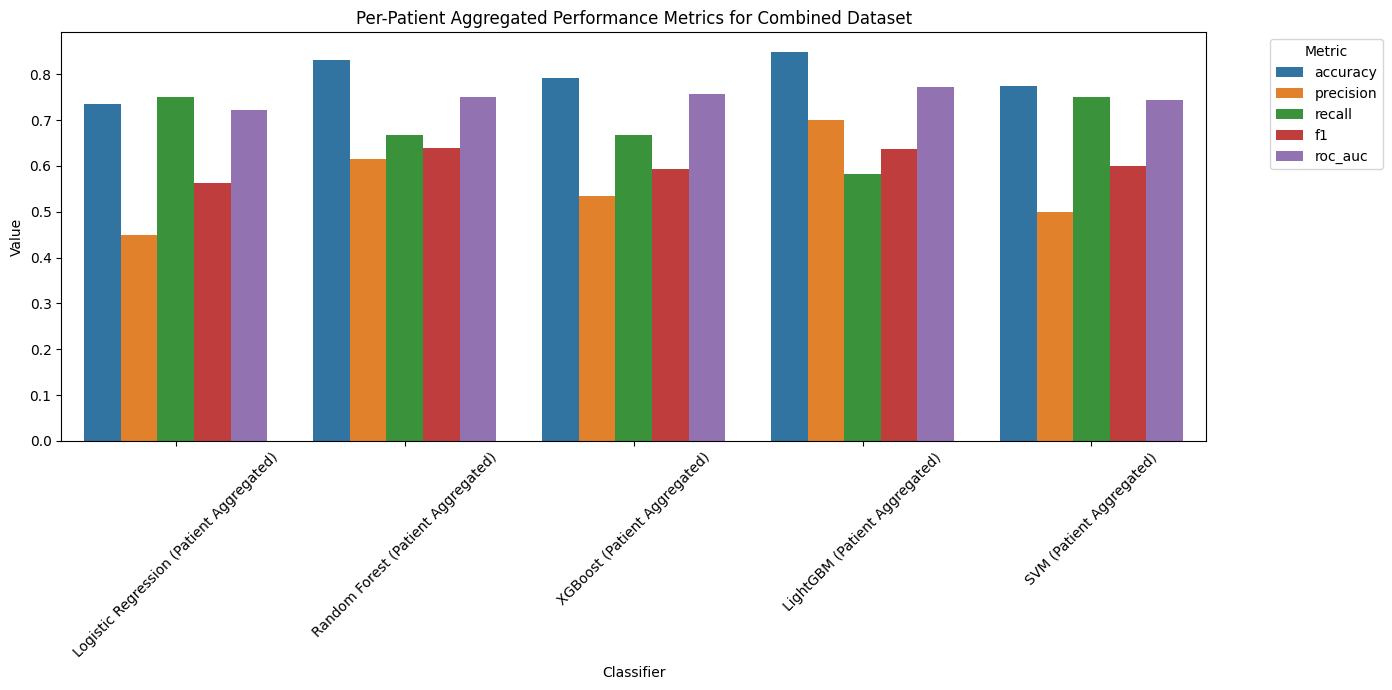

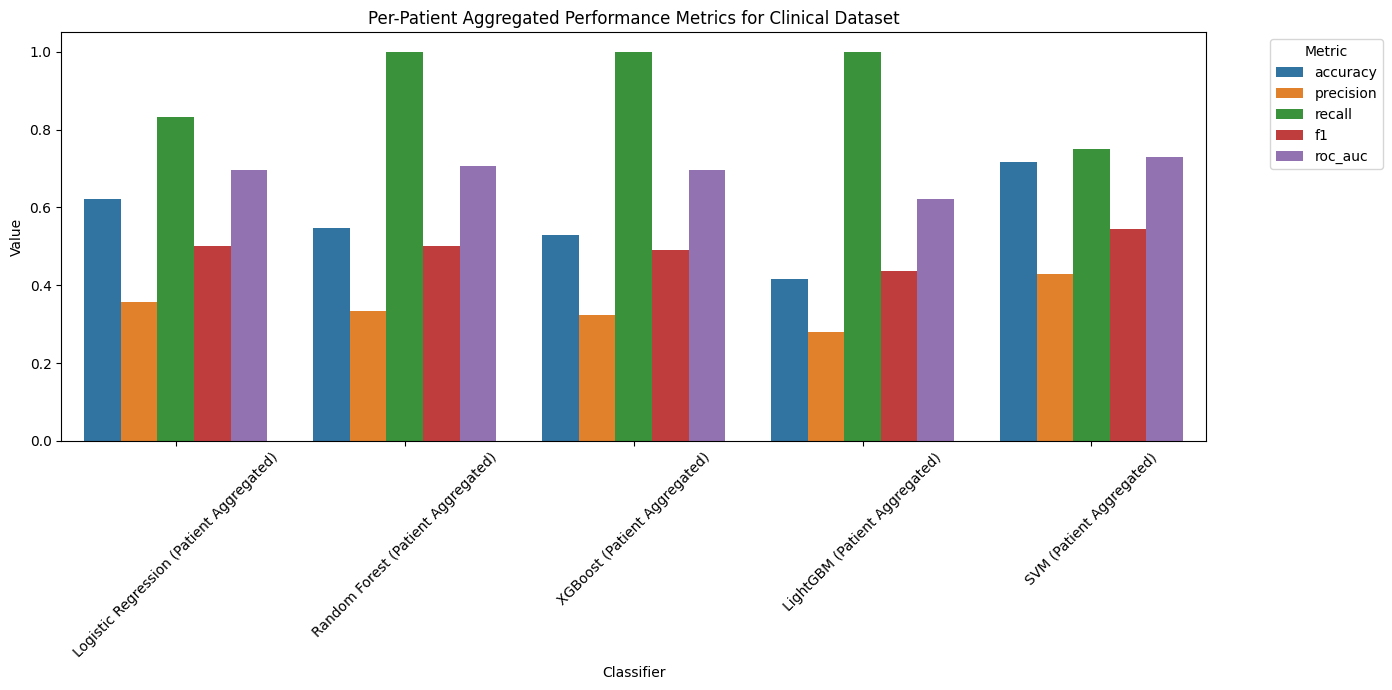

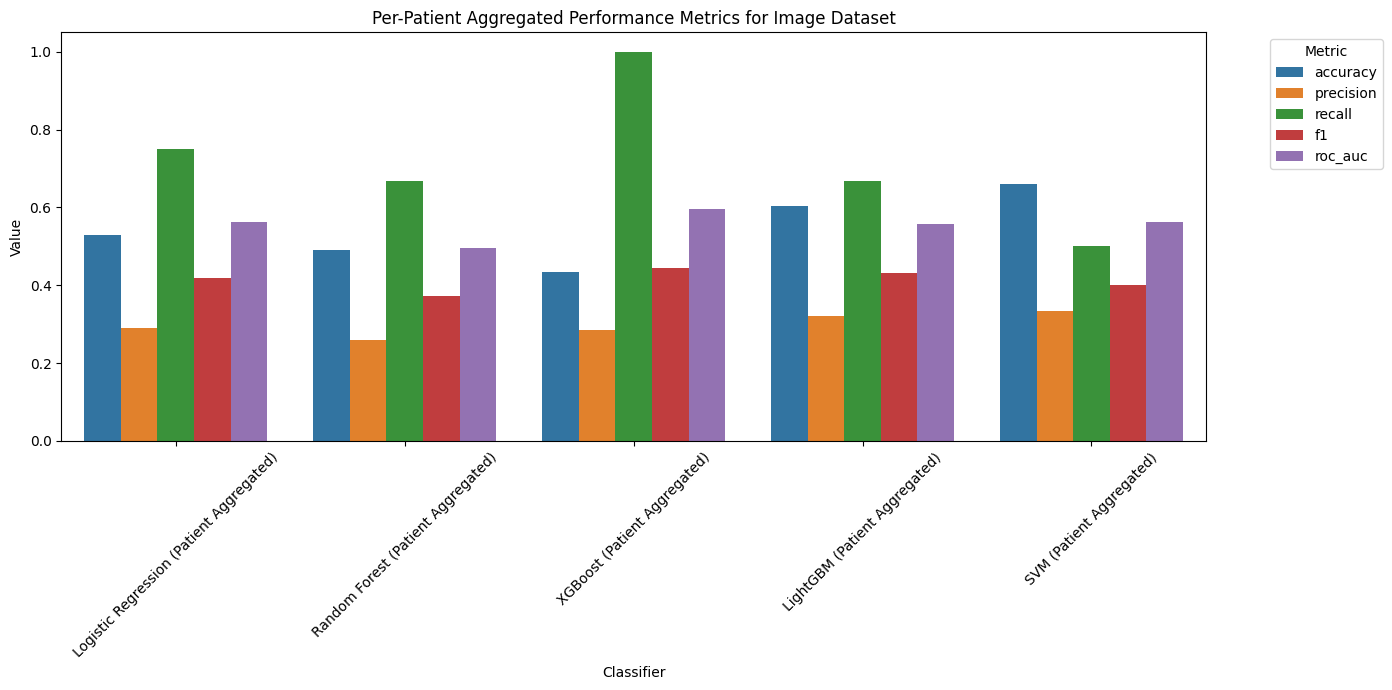

In [16]:
# New Cell: Visualize Per-Patient Performance Metrics

import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot metrics for each classifier in a dataset
def plot_metrics(dataset_name, classifiers_results):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    classifier_names = list(classifiers_results.keys())
    metric_values = {metric: [classifiers_results[clf][metric] for clf in classifier_names] for metric in metrics}
    
    df_metrics = pd.DataFrame(metric_values, index=classifier_names)
    df_metrics = df_metrics.reset_index().rename(columns={'index': 'Classifier'})
    
    df_melted = df_metrics.melt(id_vars='Classifier', var_name='Metric', value_name='Value')
    
    plt.figure(figsize=(14, 7))
    sns.barplot(x='Classifier', y='Value', hue='Metric', data=df_melted)
    plt.title(f'Per-Patient Aggregated Performance Metrics for {dataset_name} Dataset')
    plt.xticks(rotation=45)
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot metrics for each dataset
for dataset_name, classifiers_results in test_results_per_patient.items():
    plot_metrics(dataset_name, classifiers_results)
